# DataLab Cup 4 : Unlearnable Dataset
`Neural Tangent Generalization Attacks (NTGA)`

# Dataset Download
CAUTION: If you nerver download dataset from Kaggle before, plz follow the tutorial in this page: https://www.endtoend.ai/tutorial/how-to-download-kaggle-datasets-on-ubuntu/

## CIFAR-10

In [6]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-cifar-10

100%|███████████████████████████████████████▉| 241M/242M [00:24<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 242M/242M [00:24<00:00, 10.3MB/s]


In [8]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-cifar-10.zip'
zip_list(file_path)

## Imagenet

In [20]:
!kaggle competitions download -c datalab-cup4-unlearnable-datasets-imagenet

100%|█████████████████████████████████████▉| 1.21G/1.21G [01:55<00:00, 10.3MB/s]
100%|██████████████████████████████████████| 1.21G/1.21G [01:55<00:00, 11.2MB/s]


In [ ]:
import os
import zipfile

# zipfile example
def zip_list(file_path):
    zf = zipfile.ZipFile(file_path, 'r')
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    zf.extractall('./dataset')

file_path = './datalab-cup4-unlearnable-datasets-imagenet.zip'
zip_list(file_path)

# Libraries and Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.models import Sequential
import tensorflow_addons as tfa
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import trange
import cv2

from skimage.util import random_noise
from skimage import color

In [2]:
!nvidia-smi

Thu Jan 20 16:05:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 87%   88C    P2   242W / 250W |   8236MiB / 11176MiB |     81%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
|  0%   

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_memory_growth(gpus[1], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

2 Physical GPUs, 1 Logical GPUs


# Hyperparameter

In [4]:
MODE = 'cifar10'
# MODE = 'imagenet'

if MODE == 'cifar10':
    BATCH_SIZE = 512
    NUM_CLASSES = 10
    IMAGE_HEIGHT = 32
    IMAGE_WIDTH = 32
if MODE == 'imagenet':
    BATCH_SIZE = 32
    NUM_CLASSES = 2
    IMAGE_HEIGHT = 224
    IMAGE_WIDTH = 224
    
IMAGE_CHANNEL = 3
idx_show = 400

# Dataset

In [5]:
x_train = np.load(f'./dataset/x_train_{MODE}_unlearn.npy')
y_train = np.load(f'./dataset/y_train_{MODE}.npy')
x_val = np.load(f'./dataset/x_val_{MODE}.npy')
y_val = np.load(f'./dataset/y_val_{MODE}.npy')

y_train = np.argmax(y_train, axis=1)
y_val = np.argmax(y_val, axis=1)

x_test = np.load(f'./dataset/x_test_{MODE}.npy')

## Denoising Autoencoder

In [6]:
def noise(array, noise_factor=0.4):
    """
    Adds random noise to each image in the supplied array.
    """

    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [7]:
input = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(IMAGE_CHANNEL, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = tf.keras.models.Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       9248  

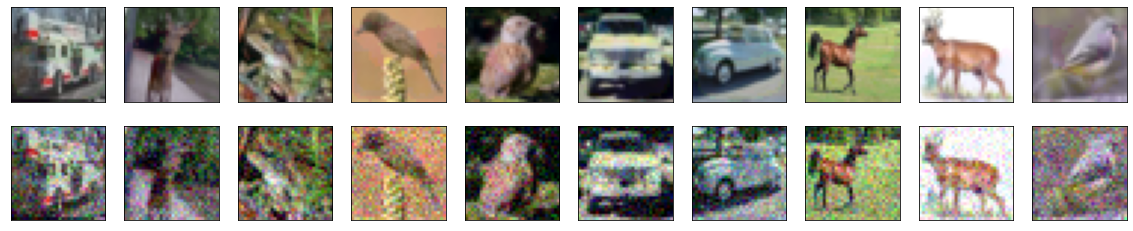

In [8]:
noise_factor = 0.1
x_train_noise = noise(x_train, noise_factor=noise_factor)
x_val_noise = noise(x_val, noise_factor=noise_factor)
display(x_train, x_train_noise)

In [ ]:
autoencoder.fit(
    x=x_train,
    y=x_train,
    epochs=50,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_val, x_val),
)

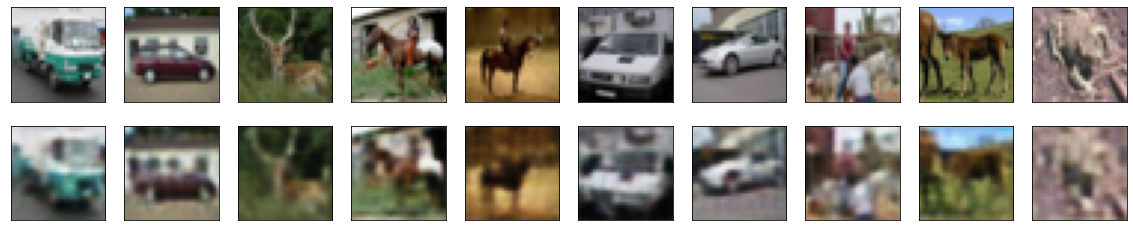

In [10]:
predictions = autoencoder.predict(x_val)
display(x_val, predictions)

In [ ]:
autoencoder.fit(
    x=x_train_noise,
    y=x_train,
    epochs=100,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_val_noise, x_val),
)

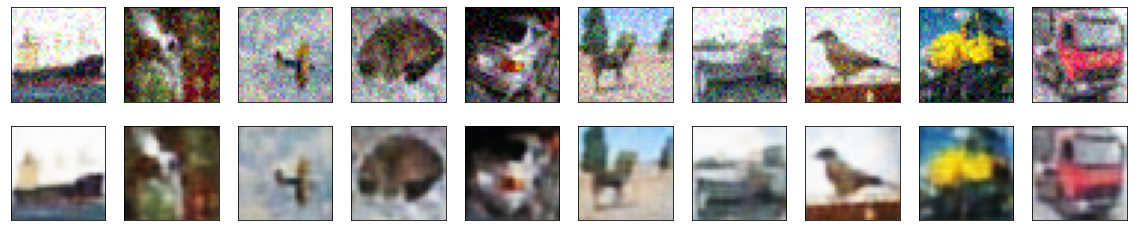

In [12]:
predictions = autoencoder.predict(x_val_noise)
display(x_val_noise, predictions)

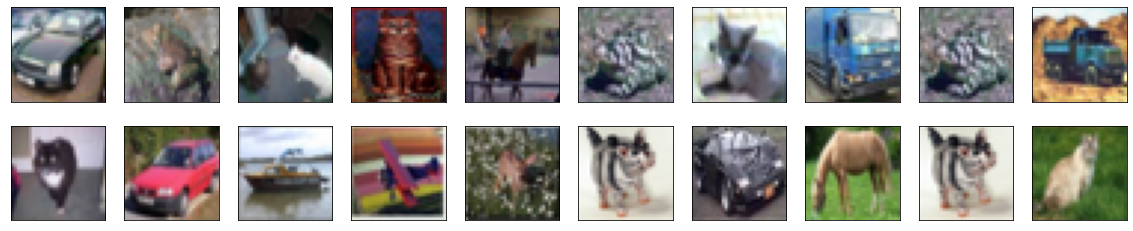

In [26]:
display(x_train[:20], x_val[:20])

In [13]:
x_train = autoencoder.predict(x_train)
x_val = autoencoder.predict(x_val)

In [35]:
np.save(f'./dataset/x_train_denoise_{MODE}', x_train)
np.save(f'./dataset/x_val_denoise_{MODE}', x_val)

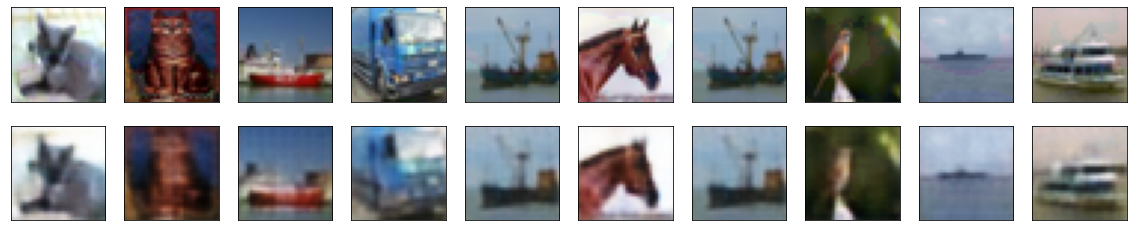

In [15]:
display(x_train[:30], x_train_denoise[:30])

## Denoising: Gaussian filter

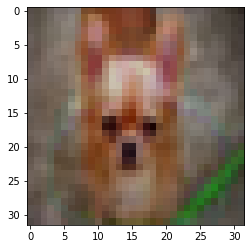

In [6]:
plt.imshow(x_train[idx_show])

In [ ]:
ks = 5
sigma = 0.5
for i in trange(len(x_train)):
    img = x_train[i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x_train[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x_train[i] = cv2.GaussianBlur(x_train[i], (ks, ks), sigma)

for i in trange(len(x_val)):
    img = x_val[i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x_val[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x_val[i] = cv2.GaussianBlur(x_val[i], (ks, ks), sigma)
    
for i in trange(len(x_test)):
    img = x_test[i]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    x_test[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    x_test[i] = cv2.GaussianBlur(x_test[i], (ks, ks), sigma)

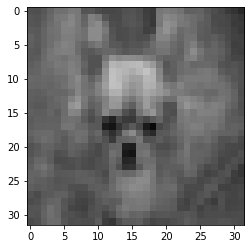

In [8]:
plt.imshow(x_train[idx_show])

## Edge detection

In [6]:
def edge_detect(x_array):
    for i in trange(len(x_array)):
        img = x_array[i]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        x_array[i] = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img = x_array[i]
        x = cv2.Sobel(img*255, cv2.CV_16S, 1, 0)
        y = cv2.Sobel(img*255, cv2.CV_16S, 0, 1)

        absX = cv2.convertScaleAbs(x)
        absY = cv2.convertScaleAbs(y)

        img = cv2.addWeighted(absX, 0.5, absY, 0.5, 0)
        x_array[i] = img / 255.

In [7]:
x_edge = x_train.copy()
edge_detect(x_edge)
# edge_detect(x_val)
# edge_detect(x_test)

100%|██████████| 40000/40000 [00:01<00:00, 29950.49it/s]


(-0.5, 31.5, 31.5, -0.5)

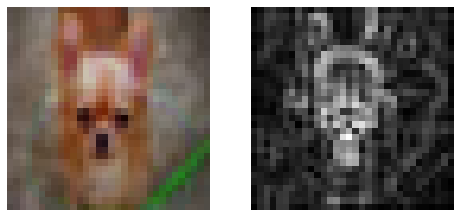

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(x_train[idx_show])
ax[0].axis('off')
ax[1].imshow(x_edge[idx_show])
ax[1].axis('off')

## Add noise to original image

In [6]:
x_train.shape

(40000, 32, 32, 3)

In [7]:
noise_g = np.random.normal(0, 0.1, size=x_train.shape)
x_noise_g = x_train + noise_g

noise_s = random_noise(x_train, mode='speckle', clip=True, mean=0, var=0.1) - x_train
x_noise_s = x_train + noise_s

x_train = np.vstack((x_train, x_noise_g))
x_train = np.vstack((x_train, x_noise_s))
print(x_train.shape)

(120000, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


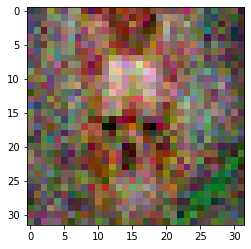

In [8]:
plt.imshow(x_noise_g[idx_show])

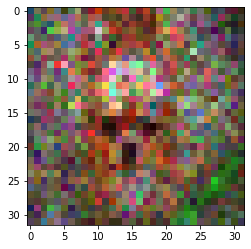

In [9]:
plt.imshow(x_noise_s[idx_show])

In [10]:
y_noise = y_train.copy()
y_noise = y_noise.reshape(-1, 1)

y_train = np.vstack((y_train.reshape(-1, 1), y_noise)).reshape(-1)
y_train = np.vstack((y_train.reshape(-1, 1), y_noise)).reshape(-1)
print(y_train.shape)

(120000,)


In [7]:
# noise_g = random_noise(x_train, mode='gaussian', clip=True, mean=0, var=0.1) - x_train
# noise_sp = random_noise(x_train, mode='s&p', clip=True, salt_vs_pepper=0.5, amount=0.02) - x_train
# noise_p = random_noise(x_train, mode='poisson', clip=True) - x_train
# noise_s = random_noise(x_train, mode='speckle', clip=True, mean=0, var=0.05) - x_train

In [7]:
# x_train = x_train + noise_g #+ noise_sp + noise_p + noise_s

(120000, 32, 32, 3) (10000, 32, 32, 3) (10000, 32, 32, 3)


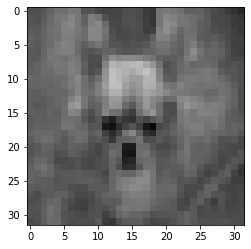

In [11]:
gray = color.rgb2gray(x_train)
x_train = color.gray2rgb(gray)
gray = color.rgb2gray(x_val)
x_val = color.gray2rgb(gray)
gray = color.rgb2gray(x_test)
x_test = color.gray2rgb(gray)
print(x_train.shape, x_val.shape, x_test.shape)
plt.imshow(x_train[idx_show])

## Data augmentation

In [12]:
MAPPING_FUNC = None

def vertical_flip(tf_img):
    return tf.image.flip_left_right(tf_img)

def horizontal_flip(tf_img):
    return tf.image.flip_up_down(tf_img)

def brightness(tf_img):
    return tf.image.random_brightness(tf_img, 0.2, 2)

def central_crop(tf_img):
    img = tf.image.central_crop(tf_img, 0.8)
    return img

def noise_injection(tf_img):
    noise = tf.random.normal(shape=tf.shape(tf_img), mean=0.0, stddev=1, dtype=tf.float32)
    return tf.add(tf_img, noise)

def grayscale(tf_img):
    img = tf.image.rgb_to_grayscale(tf_img)
    return tf.repeat(img, 3, -1)

def data_generator(image, label):
    img = image
    # img = tf.image.rgb_to_grayscale(img)
    # img = tf.image.grayscale_to_rgb(img)

    if MAPPING_FUNC is not None:
        img = MAPPING_FUNC(img)

    img = img * 255
    img = tf.keras.applications.xception.preprocess_input(img)
    label = tf.cast(label, tf.int32)    
    return img, label

def transform_dataset(image, label):
    dataset = tf.data.Dataset.from_tensor_slices((image, label))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(label))
    return dataset

In [13]:
MAPPING_FUNC = None
original_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = grayscale
# gray_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = vertical_flip
# vertical_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = horizontal_flip
# horizontal_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = brightness
# brightness_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = central_crop
# crop_dataset = transform_dataset(x_train, y_train)

# MAPPING_FUNC = noise_injection
# noise_dataset = transform_dataset(x_train, y_train)

train_dataset = original_dataset
# train_dataset = train_dataset.concatenate(gray_dataset)
# train_dataset = train_dataset.concatenate(vertical_dataset)
# train_dataset = train_dataset.concatenate(horizontal_dataset)
# train_dataset = train_dataset.concatenate(brightness_dataset)
# train_dataset = train_dataset.concatenate(crop_dataset)
# train_dataset = train_dataset.concatenate(noise_dataset)
batched_dataset = train_dataset.shuffle(len(y_train)).batch(BATCH_SIZE, drop_remainder=True)
batched_dataset = batched_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(f'Batch size: {BATCH_SIZE}, # of batch: {len(batched_dataset)}')
print(f'Total images: {len(batched_dataset)*BATCH_SIZE}')

Batch size: 512, # of batch: 234
Total images: 119808


In [14]:
MAPPING_FUNC = None
val_dataset = transform_dataset(x_val, y_val)
batched_val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class: 4
(32, 32, 3)


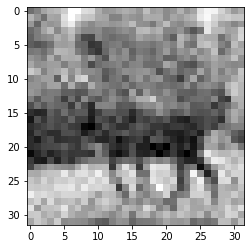

In [15]:
for data in batched_dataset.take(1):
    idx = 30
    print("Class:", data[1][idx].numpy())
    for i in range(len(data[0])):
        assert data[0][i].shape == (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)
    print(data[0][idx].shape)
    plt.imshow((data[0][idx] + 1)/2,cmap='gray')

# Model

In [ ]:
# backbone = tf.keras.applications.ResNet50(
#     include_top=False, 
#     input_tensor=keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)),
#     pooling='max',
#     weights=None)

# input = backbone.input
# output = layers.Dense(NUM_CLASSES)(backbone.output)

# model = keras.Model(input, output)
# model.summary()

In [16]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(.2, .2)],
  name='data_aug')

In [17]:
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL))
x = data_augmentation(inputs)

backbone = tf.keras.applications.Xception(
    include_top=False, 
    input_tensor=keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL)),
    pooling='max',
    weights=None)

x = backbone(x)
outputs = layers.Dense(NUM_CLASSES)(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_aug (Sequential)       (None, 32, 32, 3)         0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,827,442
Non-trainable params: 54,528
_________________________________________________________________


# Training

In [18]:
checkpoint_filepath = './checkpoints/ckpt/'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=20, monitor = 'val_loss')

In [19]:
# model.load_weights(checkpoint_filepath)

In [20]:
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['acc'])

In [21]:
history = model.fit(x=batched_dataset, validation_data=batched_val_dataset,
                    epochs=200,
                    callbacks=[checkpoint_callback, early_stop_callback])

Epoch 1/200
234/234 [==============================] - 35s 124ms/step - loss: 1.8406 - acc: 0.3367 - val_loss: 2.3025 - val_acc: 0.0994
Epoch 2/200
234/234 [==============================] - 30s 116ms/step - loss: 1.5385 - acc: 0.4592 - val_loss: 2.1999 - val_acc: 0.2418
Epoch 3/200
234/234 [==============================] - 29s 117ms/step - loss: 1.4028 - acc: 0.5096 - val_loss: 1.5518 - val_acc: 0.4531
Epoch 4/200
234/234 [==============================] - 30s 123ms/step - loss: 1.3030 - acc: 0.5462 - val_loss: 1.6977 - val_acc: 0.4772
Epoch 5/200
234/234 [==============================] - 31s 127ms/step - loss: 1.2270 - acc: 0.5733 - val_loss: 1.6677 - val_acc: 0.4975
Epoch 6/200
234/234 [==============================] - 31s 127ms/step - loss: 1.1696 - acc: 0.5950 - val_loss: 1.4838 - val_acc: 0.5372
Epoch 7/200
234/234 [==============================] - 31s 128ms/step - loss: 1.1221 - acc: 0.6119 - val_loss: 1.4147 - val_acc: 0.5514
Epoch 8/200
234/234 [===========================

# Visualize

In [ ]:
np.mean(history.history['val_acc'])

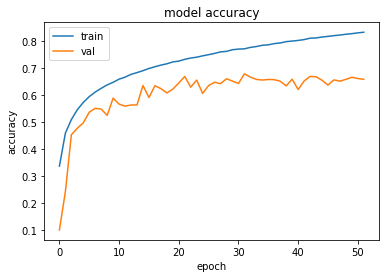

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Inference

In [48]:
x_test = np.load(f'./dataset/x_test_{MODE}.npy')
print(x_test.shape)
x_test = autoencoder.predict(x_test)
print(x_test.shape)

(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [23]:
def test_data_generator(image):    
    img = image
    # img = tf.image.rgb_to_grayscale(img)
    # img = tf.image.grayscale_to_rgb(img)

    img = img * 255
    img = tf.keras.applications.xception.preprocess_input(img)
    return img

In [24]:
# x_test = np.load(f'./dataset/x_test_{MODE}.npy')
test_dataset = tf.data.Dataset.from_tensor_slices((x_test))
test_dataset = test_dataset.map(test_data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
batched_test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=False)
print(len(x_test), len(test_dataset), len(batched_test_dataset))

10000 10000 20


In [25]:
result = model.predict(x=batched_test_dataset)
final_result = np.argmax(result, axis=1)
output = pd.DataFrame({'id':range(len(final_result)), 'label':final_result})
output.to_csv(f'./submission_{MODE}.csv', header=True, index=False)